# Problem 3, Latin Alphabet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%matplotlib inline

## A) 

In [22]:
df_train = pd.read_csv("./data/HW2_data/Q3_train.csv")
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


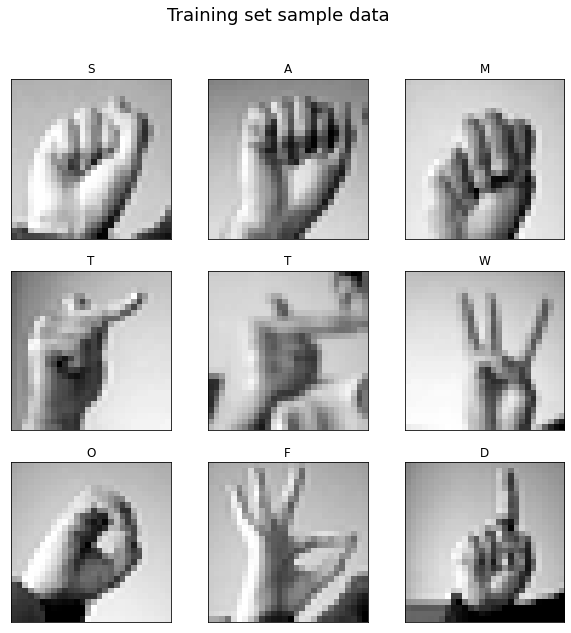

In [23]:
train_samples = df_train.sample(9).to_numpy()
fig, ax = plt.subplots(3, 3, figsize=(10,10))
fig.suptitle("Training set sample data", fontsize=18)
for i in range(9):
    ax[i//3,i%3].set_xticks([])
    ax[i//3,i%3].set_yticks([])
    ax[i//3,i%3].imshow(train_samples[i, 1:].reshape(28, 28), cmap='gray')
    ax[i//3,i%3].set_title(f"{chr(train_samples[i, 0]+65)}")
plt.show()

## B)

In [26]:
df_test = pd.read_csv("./data/HW2_data/Q3_test.csv")
df_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


## Splitting data

In [111]:
training_set = df_train.to_numpy()
raw_test_set = df_test.to_numpy()
# Divide test and validation equally
validation_set = raw_test_set[0:raw_test_set.shape[0]//2]
test_set = raw_test_set[raw_test_set.shape[0]//2:]
print(f"training set: {training_set.shape}\nvalidation set:{validation_set.shape}\ntest set:{test_set.shape}")

training set: (27455, 785)
validation set:(3586, 785)
test set:(3586, 785)


## Defining custom dataset

In [112]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class LatinAlphDataset(Dataset):
    def __init__(self, raw_set):
        self.X = raw_set[:, 1:]
        self.y = raw_set[:, 0]
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        features = torch.from_numpy(self.X[idx]).float().to(device)
        label = torch.tensor(self.y[idx], dtype=float, device=device)
        return features, label

Using cuda device


In [113]:
train_dataset = LatinAlphDataset(training_set)
validation_dataset = LatinAlphDataset(validation_set)
test_dataset = LatinAlphDataset(test_set)

## Model architecture

In [114]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 25)
        )
    def forward(self, X):
        return self.lin_stack(X)

## Hyperparameters

In [123]:
learning_rate = 1e-5
batch_size = 20
epochs = 20

## Training model

In [124]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dl):
        for batch_idx, (Xt, yt) in enumerate(train_dl):
            logits = self.model(Xt.float())
            yt = yt.type(torch.LongTensor).to(device)
            loss = self.loss_fn(logits, yt)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if batch_idx % 100 == 0:
                loss, current = loss.item(), batch_idx * len(Xt)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dl.dataset):>5d}]")
    def calAccAndLossOnSet(self, dl):
        loss, correct = 0, 0
        with torch.no_grad():
            for (X, y) in dl:
                logits = self.model(X)
                loss += self.loss_fn(logits, y.type(torch.LongTensor).to(device))
                preds = nn.Softmax(dim=1)(logits)
                correct += ( preds.argmax(dim=1) == y ).sum().item()
        loss /= len(dl)
        correct /= len(dl.dataset)
        return loss, correct

In [125]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model_sgd = Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate)

print("Training the model with SGD algorithm")
trainer1 = Trainer(model_sgd, loss_fn, optimizer)
train_losses = []
train_accs = []
validation_losses = []
validation_accs = []
for epoch in range(epochs):
    print(f"At epoch {epoch+1}")
    print("===========================")
    trainer1.train(train_dataloader)
    loss, acc = trainer1.calAccAndLossOnSet(train_dataloader)
    train_losses.append(loss)
    train_accs.append(acc)
    print(f"Train Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f}")
    loss, acc = trainer1.calAccAndLossOnSet(validation_dataloader)
    validation_losses.append(loss)
    validation_accs.append(acc)
    print(f"Validation Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

Training the model with SGD algorithm
At epoch 1
loss: 27.327301  [    0/27455]
loss: 5.426930  [ 2000/27455]
loss: 4.030181  [ 4000/27455]
loss: 4.211781  [ 6000/27455]
loss: 3.878492  [ 8000/27455]
loss: 3.293788  [10000/27455]
loss: 2.335856  [12000/27455]
loss: 2.587056  [14000/27455]
loss: 1.846028  [16000/27455]
loss: 2.108456  [18000/27455]
loss: 2.967435  [20000/27455]
loss: 1.649112  [22000/27455]
loss: 1.946551  [24000/27455]
loss: 1.929686  [26000/27455]
Train Error: 
 Accuracy: 36.2%, Avg loss: 2.305058
Validation Error: 
 Accuracy: 31.3%, Avg loss: 2.771158 

At epoch 2
loss: 2.491486  [    0/27455]
loss: 1.665683  [ 2000/27455]
loss: 2.147816  [ 4000/27455]
loss: 1.058833  [ 6000/27455]
loss: 2.267087  [ 8000/27455]
loss: 1.518555  [10000/27455]
loss: 1.700592  [12000/27455]
loss: 2.151200  [14000/27455]
loss: 2.437977  [16000/27455]
loss: 1.461403  [18000/27455]
loss: 1.339949  [20000/27455]
loss: 2.146630  [22000/27455]
loss: 1.835416  [24000/27455]
loss: 1.695416  [260

In [104]:
print(train_accs)
print(train_losses)
print(validation_accs)
print(validation_losses)
# fig, ax = plt.subplots(3, 3, figsize=(10,10))
# fig.suptitle("Training set sample data", fontsize=18)
# for i in range(9):
#     ax[i//3,i%3].set_xticks([])
#     ax[i//3,i%3].set_yticks([])
#     ax[i//3,i%3].imshow(train_samples[i, 1:].reshape(28, 28), cmap='gray')
#     ax[i//3,i%3].set_title(f"{chr(train_samples[i, 0]+65)}")
# plt.show()

NameError: name 'train_accs' is not defined